In [1]:
import yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from econml.dml import LinearDML
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

c:\Users\ccino\Documents\data_science\projects\icecream-causal\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
with open('../config.yaml', 'r') as file:
    config = yaml.safe_load(stream=file)

df = pd.read_csv(config['data']['path'])
df_rnd = pd.read_csv(config['data']['path_rnd'])
df.head()

,temp,weekday,cost,price,sales
0,17.3,6,1.5,5.6,173
1,25.4,3,0.3,4.9,196
2,23.3,5,1.5,7.6,207
3,26.9,1,0.3,5.3,241
4,20.2,1,1.0,7.2,227


In [3]:
preprocessor = ColumnTransformer(
    transformers=[
        ('weekday', OneHotEncoder(), ['weekday']),
    ],
    remainder='passthrough'
)

In [4]:
import re

preprocessor.fit(df.drop(columns=['price', 'sales']))
cols = [re.sub('.*__', '', col) for col in preprocessor.get_feature_names_out()]
df_ohe = pd.DataFrame(data=preprocessor.transform(df), columns=cols)
df_ohe.head(10)

,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7,temp,cost
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,17.3,1.5
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,25.4,0.3
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,23.3,1.5
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,26.9,0.3
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,20.2,1.0
5,0.0,0.0,0.0,0.0,0.0,1.0,0.0,26.1,0.5
6,0.0,0.0,0.0,0.0,0.0,1.0,0.0,25.0,0.3
7,0.0,0.0,0.0,0.0,1.0,0.0,0.0,18.5,0.5
8,0.0,0.0,1.0,0.0,0.0,0.0,0.0,30.1,1.0
9,0.0,0.0,0.0,0.0,1.0,0.0,0.0,19.8,0.3


In [5]:
features = df_ohe.columns
treatment = 'price'
outcome = 'sales'

In [6]:
m1 = LinearDML(
    model_t=GradientBoostingRegressor(),
    model_y=GradientBoostingRegressor(),
    cv=3,
    random_state=1
)

In [7]:
m1.fit(
    Y=df[outcome],
    T=df[treatment],
    X=df_ohe[features]
)

c:\Users\ccino\Documents\data_science\projects\icecream-causal\.venv\Lib\site-packages\econml\sklearn_extensions\linear_model.py:1815: UserWarning: Co-variance matrix is underdetermined. Inference will be invalid!
  warnings.warn("Co-variance matrix is underdetermined. Inference will be invalid!")


In [21]:
from econml.dml import CausalForestDML

m4_cfdml = CausalForestDML(
    model_t=GradientBoostingRegressor(),
    model_y=GradientBoostingRegressor(),
    cv=3,
    random_state=1
)

m4_cfdml.fit(
    Y=df[outcome],
    T=df[treatment],
    X=df_ohe[features]
)

In [8]:

df_rnd_ohe = pd.DataFrame(data=preprocessor.transform(df_rnd), columns=cols)
df_rnd_ohe.head(10)

,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7,temp,cost
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,25.8,0.3
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,22.7,0.5
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,33.7,1.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,23.0,0.5
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,24.4,1.0
5,0.0,0.0,0.0,0.0,0.0,0.0,1.0,30.3,0.5
6,1.0,0.0,0.0,0.0,0.0,0.0,0.0,20.4,1.0
7,0.0,0.0,0.0,0.0,0.0,1.0,0.0,21.6,1.0
8,0.0,0.0,0.0,0.0,0.0,1.0,0.0,24.8,0.5
9,0.0,0.0,1.0,0.0,0.0,0.0,0.0,22.7,0.5


In [9]:
df_rnd['effect'] = m1.const_marginal_effect(df_rnd_ohe[features])
df_rnd.head(10)

,temp,weekday,cost,price,sales,effect
0,25.8,1,0.3,7,230,-11.213445
1,22.7,3,0.5,4,190,-1.662531
2,33.7,7,1.0,5,237,-9.941216
3,23.0,4,0.5,5,193,-1.754526
4,24.4,1,1.0,3,252,-10.514818
5,30.3,7,0.5,9,191,-10.772547
6,20.4,1,1.0,7,222,-10.816919
7,21.6,6,1.0,8,188,-1.028721
8,24.8,6,0.5,8,192,-1.361585
9,22.7,3,0.5,6,189,-1.662531


In [22]:
df_rnd['effect_forest'] = m4_cfdml.const_marginal_effect(X=df_rnd_ohe[features])
df_rnd.head()

,temp,weekday,cost,price,sales,effect,effect_bin,weekend,m2_effect,m3_random,effect_forest
0,25.8,1,0.3,7,230,-11.213445,low,1,-13.096964,0.417022,-9.811259
1,22.7,3,0.5,4,190,-1.662531,medium,0,1.054695,0.720324,-2.948353
2,33.7,7,1.0,5,237,-9.941216,low,1,-17.362642,0.000114,-13.128643
3,23.0,4,0.5,5,193,-1.754526,medium,0,0.564985,0.302333,-3.194308
4,24.4,1,1.0,3,252,-10.514818,low,1,-13.717946,0.146756,-12.546336


In [10]:
df_rnd['effect'].describe().T

count    5000.000000
mean       -3.947765
std         4.447365
min       -12.270799
25%       -10.061504
50%        -1.523640
75%        -0.875311
max         0.575680
Name: effect, dtype: float64

In [23]:
df_rnd['effect_forest'].describe()

count    5000.000000
mean       -4.004916
std         4.885874
min       -16.223334
25%        -8.505596
50%        -2.532037
75%        -0.285712
max         4.237056
Name: effect_forest, dtype: float64

In [11]:
df_rnd['effect_bin'] = pd.qcut(df_rnd['effect'], 3, labels=['low', 'medium', 'high'])
df_rnd['weekend'] = np.select([df_rnd['weekday'] == 1, df_rnd['weekday'] == 7], [1, 1], 0)

In [12]:
df_rnd.groupby(by='effect_bin')[['effect']].mean()

C:\Users\ccino\AppData\Local\Temp\ipykernel_4296\4292504786.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_rnd.groupby(by='effect_bin')[['effect']].mean()


,effect
effect_bin,
low,-9.747391
medium,-1.533174
high,-0.560697


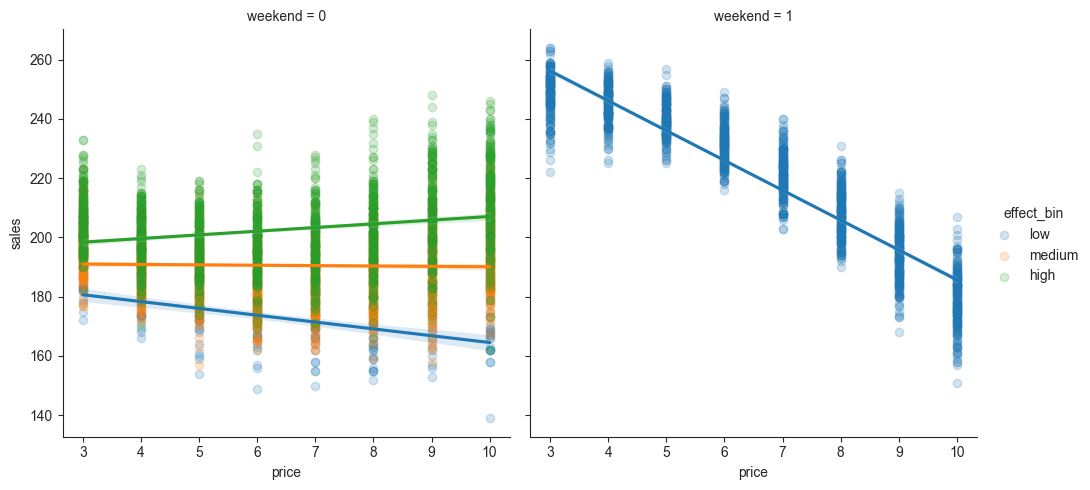

In [13]:
sns.set_style('ticks')
sns.lmplot(data=df_rnd, x='price', y='sales', hue='effect_bin', col='weekend', scatter_kws={'alpha':0.2})

In [14]:
def sensitivity(data: pd.DataFrame, y, t):
    # line coeficient for the one variable linear regression 
    x1 = data[t].cov(data[y])
    x2 = data[t].var()
    return x1/x2

In [15]:
sensitivity(df_rnd, 'sales', 'price')

np.float64(-2.5516260830125876)

In [16]:
from statsmodels.formula.api import ols
np.random.seed(1)
m2 = ols(formula='sales ~ price*(temp + C(weekday) + cost)', data=df).fit()
m2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  sales   R-squared:                       0.808
Model:                            OLS   Adj. R-squared:                  0.808
Method:                 Least Squares   F-statistic:                     2470.
Date:                Sun, 24 Aug 2025   Prob (F-statistic):               0.00
Time:                        15:06:40   Log-Likelihood:                -35604.
No. Observations:               10000   AIC:                         7.124e+04
Df Residuals:                    9982   BIC:                         7.137e+04
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept               200.1113      3.188     62.769      0.000     193.862     206.361
C(weekday)[T.2]        -118.5501      1.824    -64.992      0.000    -122.126    -114.975
C(weekday)[T.3]        -120.3301      1.873    -64.237      0.000    -124.002    -116.658
C(weekday)[T.4]        -118.2078      1.855    -63.713      0.000    -121.845    -114.571
C(weekday)[T.5]        -119.6481      1.870    -63.984      0.000    -123.314    -115.983
C(weekday)[T.6]        -119.5366      1.855    -64.428      0.000    -123.174    -115.900
C(weekday)[T.7]           0.5810      1.959      0.297      0.767      -3.259       4.421
price                    -2.6762      0.505     -5.297      0.000      -3.667      -1.686
price:C(weekday)[T.2]    12.9438      0.283     45.767      0.000      12.389      13.498
price:C(weekday)[T.3]    13.2905      0.292     45.583      0.000      12.719      13.862
price:C(weekday)[T.4]    12.9162      0.288     44.889      0.000      12.352      13.480
price:C(weekday)[T.5]    13.1615      0.290     45.412      0.000      12.593      13.730
price:C(weekday)[T.6]    13.2000      0.288     45.759      0.000      12.635      13.765
price:C(weekday)[T.7]    -0.0675      0.284     -0.238      0.812      -0.624       0.489
temp                      4.1991      0.113     37.134      0.000       3.977       4.421
cost                     13.8445      1.043     13.278      0.000      11.801      15.888
price:temp               -0.3846      0.018    -21.187      0.000      -0.420      -0.349
price:cost               -1.6564      0.163    -10.177      0.000      -1.975      -1.337
==============================================================================
Omnibus:                      166.507   Durbin-Watson:                   1.966
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              307.968
Skew:                           0.095   Prob(JB):                     1.34e-67
Kurtosis:                       3.839   Cond. No.                     7.56e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.56e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [17]:
df_rnd['m2_effect'] = m2.predict(df_rnd.assign(price=df_rnd['price'] + 1)) - m2.predict(df_rnd)
df_rnd['m3_random'] = np.random.uniform(size=5000)
df_rnd.head(10)

,temp,weekday,cost,price,sales,effect,effect_bin,weekend,m2_effect,m3_random
0,25.8,1,0.3,7,230,-11.213445,low,1,-13.096964,0.417022
1,22.7,3,0.5,4,190,-1.662531,medium,0,1.054695,0.720324
2,33.7,7,1.0,5,237,-9.941216,low,1,-17.362642,0.000114
3,23.0,4,0.5,5,193,-1.754526,medium,0,0.564985,0.302333
4,24.4,1,1.0,3,252,-10.514818,low,1,-13.717946,0.146756
5,30.3,7,0.5,9,191,-10.772547,low,1,-15.226640,0.092339
6,20.4,1,1.0,7,222,-10.816919,low,1,-12.179362,0.186260
7,21.6,6,1.0,8,188,-1.028721,high,0,0.559057,0.345561
8,24.8,6,0.5,8,192,-1.361585,medium,0,0.156394,0.396767
9,22.7,3,0.5,6,189,-1.662531,medium,0,1.054695,0.538817


In [40]:
def plot_gain(data: pd.DataFrame, order_col, y, t, normalize=True):

    def sensitivity(data: pd.DataFrame, y, t):
        # line coeficient for the one variable linear regression 
        x1 = data[t].cov(data[y])
        x2 = data[t].var()
        return x1/x2

    data_len = data.shape[0]
    batch_list = np.arange(start=29, stop=data_len) + 1
    data_ordered = data.sort_values(by=order_col, ascending=False)
    if normalize:
        sensi_list = [sensitivity(data_ordered.head(batch), y=y, t=t)*(batch/data_len) for batch in batch_list]
    else:
        sensi_list = [sensitivity(data_ordered.head(batch), y=y, t=t) for batch in batch_list]

    return np.array(sensi_list)

AUUC effect: 2.40
AUUC m2_effect: 2.14
AUUC m3_random: 1.27
AUUC effect_forest: 2.48


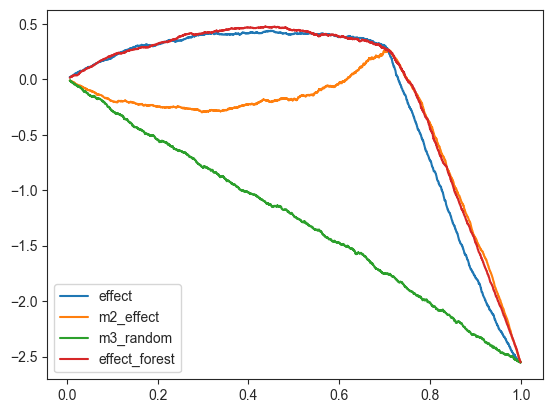

In [42]:
data_len = df_rnd.shape[0]
batch_list = (np.arange(start=29, stop=data_len) + 1) / data_len
max_sensi = sensitivity(data=df_rnd, y='sales', t='price')
np.random.seed(1)
for col in ['effect', 'm2_effect', 'm3_random', 'effect_forest']:
    sensi = plot_gain(df_rnd, col, 'sales', 'price')
    plt.plot(batch_list, sensi, label=col)
    AUUC = np.trapezoid(y=sensi-max_sensi, x=batch_list)
    print(f'AUUC {col}: {AUUC:.2f}')

plt.legend()

Now, to make this model useful, let's make a function to get the top k customers with the highest sensitivity among all customers

In [43]:
def top_k_customers(df, col, k=100):
    col_sort = np.argsort(df[col])[:k]
    customers = df.loc[col_sort, :].copy()
    return customers

In [44]:
for kth in np.linspace(0.1, 1.0, 10):
    index = np.round(kth*5000).astype(int)
    customers = top_k_customers(df_rnd, 'effect_forest', k=index)
    sensi = sensitivity(customers, y='sales', t='price')
    print(f'kth: {kth:.2f}: {sensi:.3f}')

kth: 0.10: -11.306
kth: 0.20: -10.770
kth: 0.30: -9.806
kth: 0.40: -7.485
kth: 0.50: -6.012
kth: 0.60: -5.047
kth: 0.70: -4.243
kth: 0.80: -3.558
kth: 0.90: -3.064
kth: 1.00: -2.552


Interpreting the model with Trees

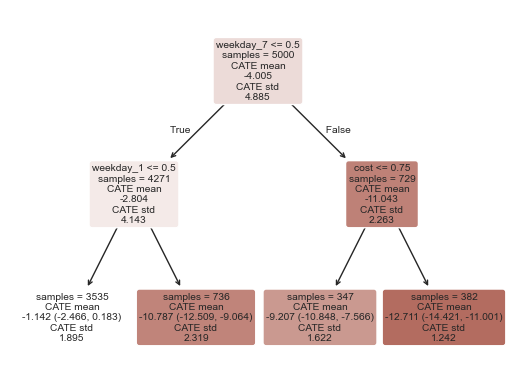

In [47]:
from econml.cate_interpreter import SingleTreeCateInterpreter, SingleTreePolicyInterpreter

# let's interpret the causal m4 model
interpreter = SingleTreeCateInterpreter(include_model_uncertainty=True, max_depth=2, min_samples_leaf=10)
interpreter.interpret(m4_cfdml, df_rnd_ohe[features])
interpreter.plot(feature_names=features)